#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [19]:
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from datetime import datetime

In [24]:
# Константы
SAMPLE_SIZE = 200
RS = 12345
CRIT_RMSE = 48

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные отсортированы по времени: True
Имеем данные за период: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


<AxesSubplot:title={'center':'Исходные значения'}, xlabel='Время заказа', ylabel='Количество заказов'>

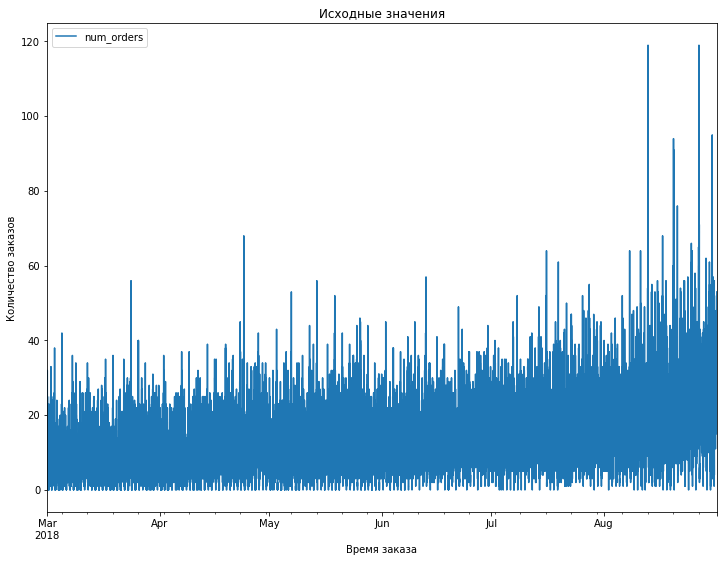

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
display(data.head())
display(data.describe())
data.sort_index(inplace=True)
print('Данные отсортированы по времени:', data.index.is_monotonic)
print('Имеем данные за период:', data.index.min(), '-', data.index.max())
data.plot(figsize=[12,9], title='Исходные значения', xlabel='Время заказа', ylabel='Количество заказов')

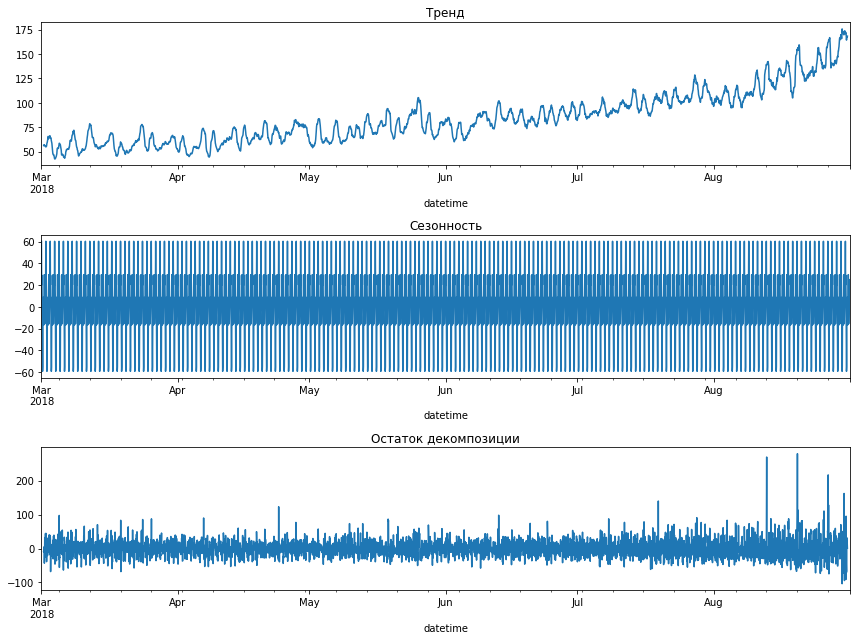

In [3]:
data = data.resample('1H').sum()
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(12,9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()

Text(0.5, 1.0, 'Сезонность за май')

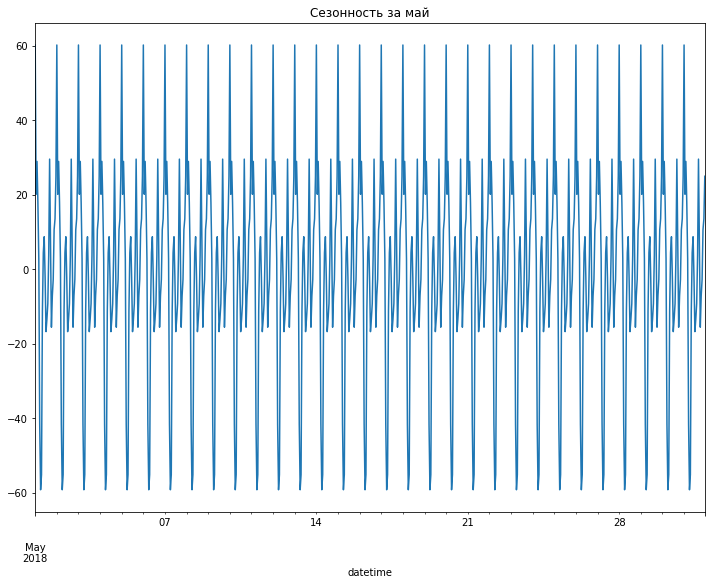

In [4]:
plt.figure(figsize=(12,9))
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca()) 
plt.title('Сезонность за май')

<AxesSubplot:title={'center':'Значения ресемплированные с интервалом в 1 час'}, xlabel='Время заказа', ylabel='Количество заказов'>

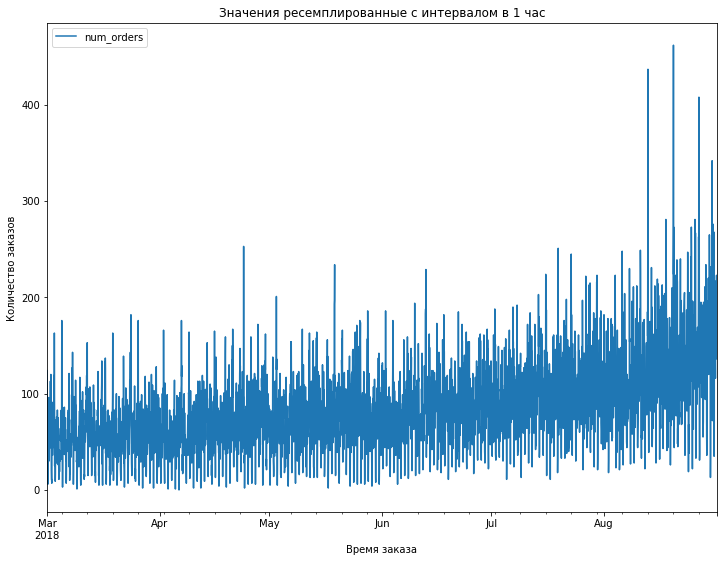

In [5]:
data.plot(figsize=[12,9], title='Значения ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')

## Анализ

<AxesSubplot:title={'center':'Значения, скользящее среднее, стандартное отклонение, ресемплированные с интервалом в 1 час'}, xlabel='Время заказа', ylabel='Количество заказов'>

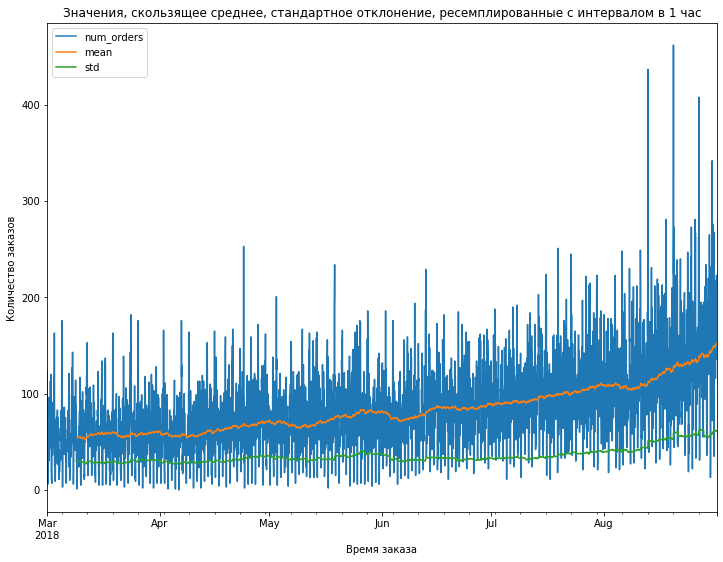

In [6]:
data['mean'] = data['num_orders'].rolling(SAMPLE_SIZE).mean()
data['std'] = data['num_orders'].rolling(SAMPLE_SIZE).std()
data.plot(figsize=[12,9], title='Значения, скользящее среднее, стандартное отклонение, ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Разности временного ряда, скользящее среднее, стандартное отклонение'}, xlabel='Время заказа', ylabel='Разности'>

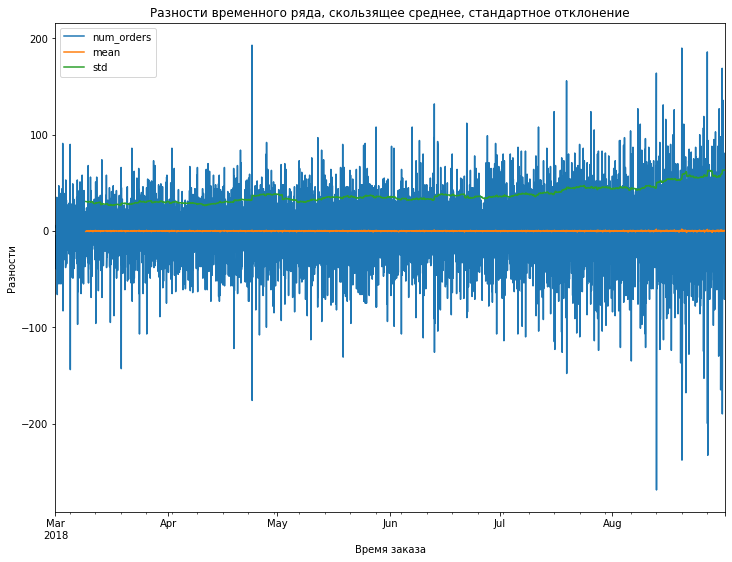

In [7]:
# Берем разностии заменяем ими временной ряд, чтобы иметь возможность его предсказывать
delta = data.shift()
data = data - delta
data['mean'] = data['num_orders'].rolling(SAMPLE_SIZE).mean()
data['std'] = data['num_orders'].rolling(SAMPLE_SIZE).std()
data.plot(figsize=[12,9], title='Разности временного ряда, скользящее среднее, стандартное отклонение', xlabel='Время заказа', ylabel='Разности')

## Обучение

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 1, 24)

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print('Размерность обучающей выборки:', train.shape)
print('Размерность тестовой выборки:', test.shape)
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Размерность обучающей выборки: (3774, 7)
Размерность тестовой выборки: (442, 7)


In [10]:
%%time

model = LinearRegression()
model.fit(train_features, train_target)
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

print("MAE обучающей выборки:", mean_absolute_error(train_target, pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(test_target, pred_test))

rmse = mean_squared_error(test_target, pred_test, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели LinearRegression на тестовой выборке: {np.round(rmse, 2)}')

MAE обучающей выборки: 22.976281582547177
MAE тестовой выборки:  38.4784856456532
Метрика RMSE модели LinearRegression на тестовой выборке: 49.21
CPU times: user 35.7 ms, sys: 39.4 ms, total: 75.1 ms
Wall time: 71.2 ms


In [22]:
%%time

params = {'depth': [4, 6, 8, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,8],
         'iterations': [100, 200, 300]}
cbr = CatBoostRegressor(silent=True)
cbr_model = GridSearchCV(cbr, params, scoring="roc_auc", cv = 3)
cbr_model.fit(test_features, test_target)

print("Лучшие параметры для модели CatBoostRegressor определенные GridSearchCV:",cbr_model.best_params_)

Лучшие параметры для модели CatBoostRegressor определенные GridSearchCV: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
CPU times: user 3min 22s, sys: 7.65 s, total: 3min 29s
Wall time: 6min 7s


## Тестирование

In [27]:
%%time

random_state = 12345

models = [LinearRegression(),          
          Ridge(random_state=RS, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          ElasticNet(),
          Lasso(random_state=RS, max_iter=1000),
          DecisionTreeRegressor(random_state=RS, max_depth=6),
          RandomForestRegressor(random_state=RS, n_estimators=80, max_depth=6),
          XGBRegressor(),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=1, learning_rate=0.03, bootstrap_type='MVS', depth=4, grow_policy='Depthwise', iterations=200, silent=True, random_seed=12345),
          LGBMRegressor(objective="regression_l2", n_estimators=50),
          DummyRegressor(strategy="median")]

results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(train_features, train_target)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    pred = md.predict(test_features)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(test_target, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(test_target, pred), 3)
    print('-- RMSE:', md_rmse)
    print('-- R2:', md_r2)
    results.append({'Модель': md.__class__.__name__, 
                    'RMSE': md_rmse,
                    'R2': md_r2,
                    'Время_обучения': dt1,
                    'Время_предсказания': dt2,                    
                    'Гиперпараметры': md.get_params(deep=False),
                    'Модель_пригодна': md_rmse<=CRIT_RMSE,
                    'pred': pred}) 
    print('')
              
results = pd.DataFrame(results)
display(results.drop('pred', axis=1))

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
-- модель обучена
-- получены предсказания
-- RMSE: 49.21
-- R2: 0.301

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': False, 'random_state': 12345, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- получены предсказания
-- RMSE: 49.21
-- R2: 0.301

Идут вычисления по модели ElasticNet: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- RMSE: 53.58
-- R2: 0.171

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 12345, 'selecti

,Модель,RMSE,R2,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LinearRegression,49.21,0.301,0.0s,0.0s,"{'copy_X': True, 'fit_intercept': True, 'n_job...",False
1,Ridge,49.21,0.301,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
2,ElasticNet,53.58,0.171,0.09s,0.01s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
3,Lasso,49.60,0.290,0.09s,0.01s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
4,DecisionTreeRegressor,49.67,0.288,0.01s,0.08s,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",False
5,RandomForestRegressor,38.37,0.575,0.52s,0.01s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,XGBRegressor,36.04,0.625,92.31s,0.05s,"{'objective': 'reg:squarederror', 'base_score'...",True
7,CatBoostRegressor,35.33,0.640,0.87s,0.0s,"{'iterations': 200, 'learning_rate': 0.03, 'de...",True
8,LGBMRegressor,35.88,0.628,142.93s,0.09s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
9,DummyRegressor,58.86,-0.000,0.0s,0.0s,"{'constant': None, 'quantile': None, 'strategy...",False


CPU times: user 3min 52s, sys: 2.58 s, total: 3min 55s
Wall time: 3min 57s


Сравнение данных по результату предсказания модели RandomForestRegressor:


,diff_num_orders,pred,error
datetime,,,
2018-08-13 14:00:00,102.0,134.808168,-32.808168
2018-08-13 15:00:00,175.0,149.433324,25.566676
2018-08-13 16:00:00,144.0,164.473413,-20.473413
2018-08-13 17:00:00,152.0,171.184894,-19.184894
2018-08-13 18:00:00,104.0,143.560993,-39.560993


Сравнение данных по результату предсказания модели XGBRegressor:


,diff_num_orders,pred,error
datetime,,,
2018-08-13 14:00:00,102.0,134.720047,-32.720047
2018-08-13 15:00:00,175.0,149.250915,25.749085
2018-08-13 16:00:00,144.0,164.427335,-20.427335
2018-08-13 17:00:00,152.0,171.119959,-19.119959
2018-08-13 18:00:00,104.0,143.558580,-39.558580


Сравнение данных по результату предсказания модели CatBoostRegressor:


,diff_num_orders,pred,error
datetime,,,
2018-08-13 14:00:00,102.0,115.691490,-13.691490
2018-08-13 15:00:00,175.0,111.847324,63.152676
2018-08-13 16:00:00,144.0,154.983525,-10.983525
2018-08-13 17:00:00,152.0,157.457188,-5.457188
2018-08-13 18:00:00,104.0,145.226440,-41.226440


Сравнение данных по результату предсказания модели LGBMRegressor:


,diff_num_orders,pred,error
datetime,,,
2018-08-13 14:00:00,102.0,129.663698,-27.663698
2018-08-13 15:00:00,175.0,138.432047,36.567953
2018-08-13 16:00:00,144.0,162.338982,-18.338982
2018-08-13 17:00:00,152.0,167.626744,-15.626744
2018-08-13 18:00:00,104.0,144.796907,-40.796907


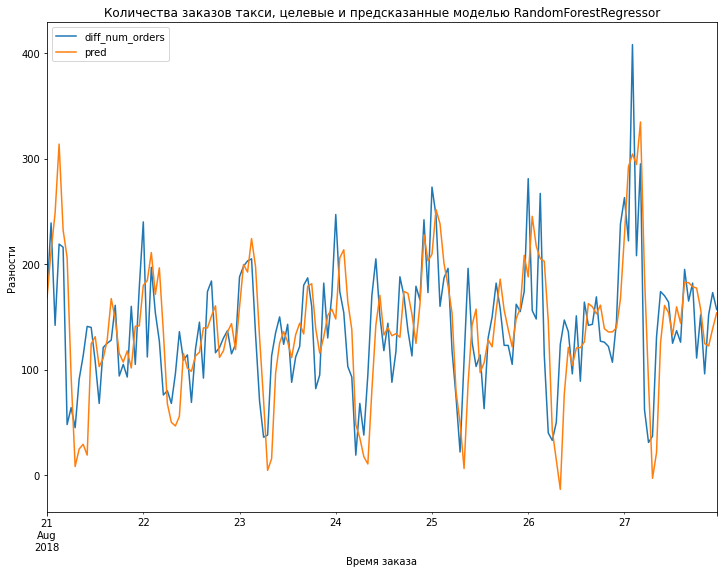

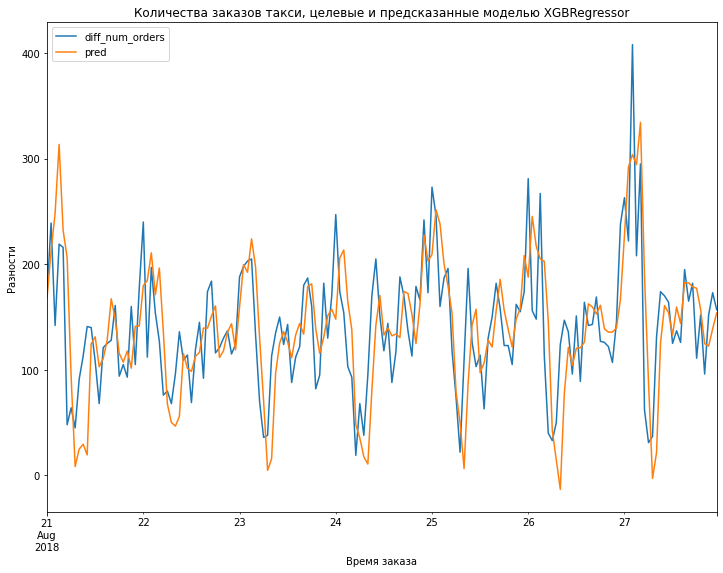

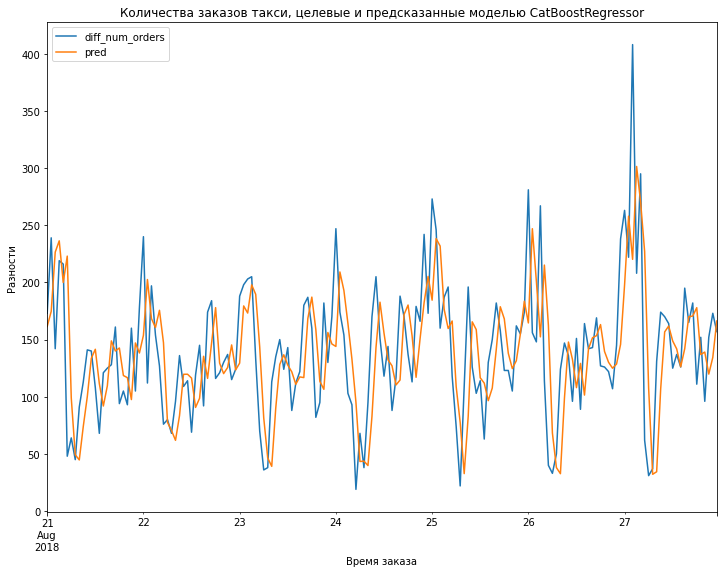

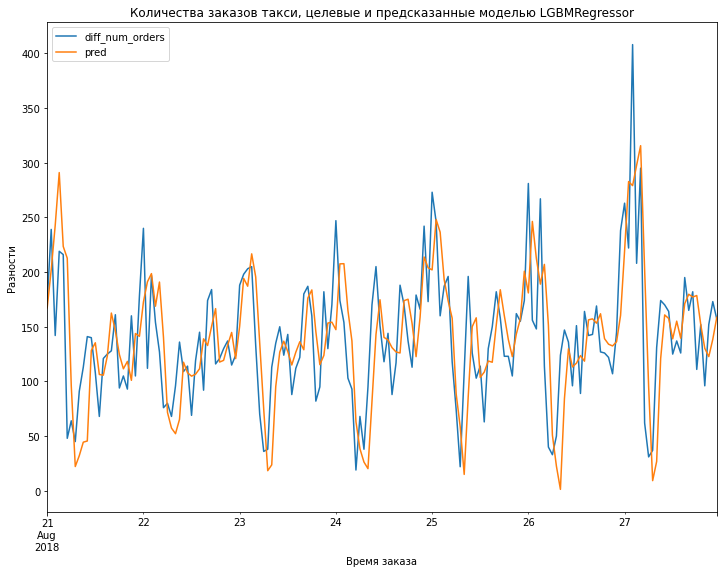

In [32]:
delta_train, delta_test = train_test_split(delta, shuffle=False, test_size=0.1) #Получили дельты для тестовой выборки
delta_test_target = delta_test['num_orders']

model_list = results.query('Модель_пригодна==True')['Модель'].tolist()
for md in range(len(model_list)):
# Создаем временный датафрейм для сравнения целевых и предсказанных значений
    r = results.loc[md, 'pred']
    diff_test_target = pd.DataFrame()
    diff_test_target['diff_num_orders'] = test_target
    diff_test_target['pred'] = r
    diff_test_target['delta'] = delta_test_target
# Возвращаемся из разностей к исходным значениям    
    diff_test_target['diff_num_orders'] = diff_test_target['diff_num_orders'] + diff_test_target['delta']
    diff_test_target['pred'] = diff_test_target['pred'] + diff_test_target['delta']
    diff_test_target = diff_test_target.drop('delta', axis=1)
# Выводим результаты    
    diff_test_target['2018-08-21':'2018-08-27'].plot(figsize=[12,9], title='Количества заказов такси, целевые и предсказанные моделью {}'.format(model_list[md]), xlabel='Время заказа', ylabel='Разности')
    diff_test_target['error'] = diff_test_target['diff_num_orders'] - diff_test_target['pred']
    print('Сравнение данных по результату предсказания модели {}:'.format(model_list[md]))
    display(diff_test_target.head())

## Выводы:
1. При заданных гиперпараметрах, наилучшая метрика RMSE получилась для модели CatBoostRegressor, она же имеет малое время предсказания
2. При заданных гиперпараметрах, самые долгие предсказания - у моделей LGBMRegressor и XGBRegressor
3. Качество предсказания даже у самой лучшей модели довольно низкое (R2=0.685), но в заданный порог RMSE<=48 укладываются многие из моделей: RandomForestRegressor, XGBRegressor, CatBoostRegressor, LGBMRegressor